In [1]:
#import scrublet as scr
import numpy as np
import pandas as pd
import statistics as st
import re
import csv
import scanpy as sc 
import scanpy.external as sce
import phate
import matplotlib
from matplotlib import pyplot as plt
import warnings
from scipy.stats import binom
from scipy.stats import multinomial
import seaborn
from scipy.stats import hypergeom
import warnings
warnings.filterwarnings('ignore')
import scrublet as scr
import harmonypy as hm

def adjust_feature(feature_matrix, feature_id):
    c, f = feature_matrix.shape
    feature_matrix = feature_matrix.copy().todense()
    
    for i in np.arange(f):
        feature_umi_array = np.asarray(feature_matrix[:,i]).squeeze()

        feature_umi_array_sort = feature_umi_array[np.argsort(feature_umi_array * -1)]
        feature_cumsum = np.cumsum(feature_umi_array_sort)

        cell_num = np.sum(feature_umi_array_sort > 0)

        turn_point = np.sum(np.diff(feature_cumsum) / np.sum(feature_umi_array) > (1 / cell_num))
        feature_matrix[np.where(feature_umi_array < feature_umi_array_sort[turn_point]), i] = 0
        
    return feature_matrix

In [2]:
working_dir = ''

In [3]:
ds = sc.read_10x_h5(working_dir + 'filtered_feature_bc_matrix.h5', gex_only=False)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [4]:
ds.var_names_make_unique()

In [5]:
ds.obs_names_make_unique()

### Filter Data

In [6]:
#merget gene index
c_num, g_num = ds.X.shape

all_singlet_idx = np.asarray(ds.obs.index)


#get the high mito cells
mt_index = ds.var.index[ds.var.index.str.startswith('MT-')].tolist()
mt_expr = np.sum(ds[:,mt_index].X, axis=1)
depth = np.sum(ds.X, axis=1)
high_mito_idx = np.argwhere((mt_expr / depth) > 0.2)[:,0].squeeze()

#get the gene and cell index
chosen_cell_index = np.setdiff1d(all_singlet_idx, all_singlet_idx[high_mito_idx])

#filter the matrix
adata = ds[chosen_cell_index, :]

sc.pp.filter_genes(adata, min_counts=1)         # only consider genes with more than 1 count
sc.pp.normalize_per_cell(adata, key_n_counts='n_counts_all') # normalize with total UMI count per cell # select highly-variable genes  # subset the genes


sc.pp.log1p(adata)
adata.raw = adata
sc.pp.scale(adata) 

Trying to set attribute `.var` of view, copying.


Text(0.5, 0, 'Mito Gene Expr (log10)')

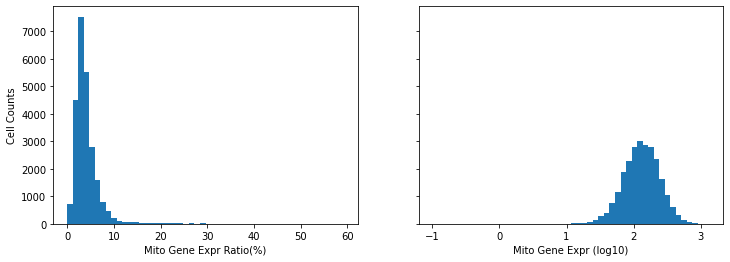

In [7]:
## check the mito gene expr
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(12,4), sharey=True)
ax1.hist(mt_expr / depth * 100, bins=50)
ax1.set_xlabel('Mito Gene Expr Ratio(%)')
ax1.set_ylabel('Cell Counts')

ax2.hist(np.log10(mt_expr+0.1), bins=50)
ax2.set_xlabel('Mito Gene Expr (log10)')

In [8]:
### Assign technical rep label
adata.obs['T_Reps'] = [''] * adata.X.shape[0]
for cell_index in adata.obs.index:
    if cell_index.split('-')[-1] == '1':
        adata.obs['T_Reps'][cell_index] = 'WT-T1_B1'
    elif cell_index.split('-')[-1] == '2':
        adata.obs['T_Reps'][cell_index] = 'WT-T2_B1'
    elif cell_index.split('-')[-1] == '3':
        adata.obs['T_Reps'][cell_index] = 'WT-T1_B2'
    elif cell_index.split('-')[-1] == '4':
        adata.obs['T_Reps'][cell_index] = 'WT-T2_B2'
    elif cell_index.split('-')[-1] == '5':
        adata.obs['T_Reps'][cell_index] = 'PROM1-T1_B1'
    elif cell_index.split('-')[-1] == '6':
        adata.obs['T_Reps'][cell_index] = 'PROM1-T2_B1'
    elif cell_index.split('-')[-1] == '7':
        adata.obs['T_Reps'][cell_index] = 'PROM1-T1_B2'
    elif cell_index.split('-')[-1] == '8':
        adata.obs['T_Reps'][cell_index] = 'PROM1-T2_B2' 
    elif cell_index.split('-')[-1] == '9':
        adata.obs['T_Reps'][cell_index] = 'ENH3-T1_B1'
    elif cell_index.split('-')[-1] == '10':
        adata.obs['T_Reps'][cell_index] = 'ENH3-T2_B1'
    elif cell_index.split('-')[-1] == '11':
        adata.obs['T_Reps'][cell_index] = 'ENH3-T1_B2'
    elif cell_index.split('-')[-1] == '12':
        adata.obs['T_Reps'][cell_index] = 'ENH3-T2_B2'
    elif cell_index.split('-')[-1] == '13':
        adata.obs['T_Reps'][cell_index] = 'ENH5-T1_B1'
    elif cell_index.split('-')[-1] == '14':
        adata.obs['T_Reps'][cell_index] = 'ENH5-T2_B1'
    elif cell_index.split('-')[-1] == '15':
        adata.obs['T_Reps'][cell_index] = 'ENH5-T1_B2'
    else:
        adata.obs['T_Reps'][cell_index] = 'ENH5-T2_B2'

In [9]:
### Assign Biological Replicate Label
Bio_rep = []
Sample = []

for cell in adata.obs.index:
    Sample.append(adata[cell].obs.T_Reps.values[0].split('-')[0])
    Bio_rep.append(adata[cell].obs.T_Reps.values[0].split('-')[0] + ':' + adata[cell].obs.T_Reps.values[0].split('_')[1])
adata.obs['B_Reps'] = Bio_rep
adata.obs['Sample'] = Sample

### Cluster Cells

In [10]:
sc.tl.pca(adata, random_state= 0)

In [11]:
sc.pp.neighbors(adata,use_rep='X_pca',random_state = 0)

del adata.uns['paga']
del adata.uns['louvain']
del adata.obs['louvain']
del adata.uns['louvain_colors']
del adata.uns['louvain_sizes']

In [32]:
sc.tl.louvain(adata,resolution = 0.05,random_state = 0)

In [33]:
sc.tl.paga(
    adata,
    groups='louvain', 
)

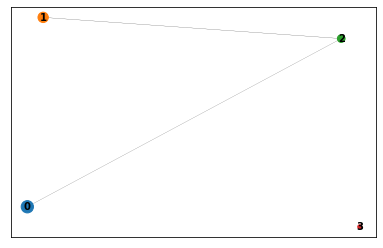

In [34]:
sc.pl.paga(
    adata, 
    color=['louvain'], 
    use_raw=True,
    layout='fr',
    threshold=0.01,
    node_size_scale=0.5,
    node_size_power=0.9,
    edge_width_scale=1,
)

In [35]:
sc.tl.umap(
    adata,
    init_pos='paga',
    random_state = 0
)

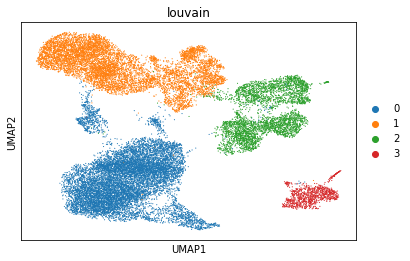

In [36]:
sc.pl.umap(
    adata,
    color=['louvain'], 
    vmin=0, vmax= 100
)

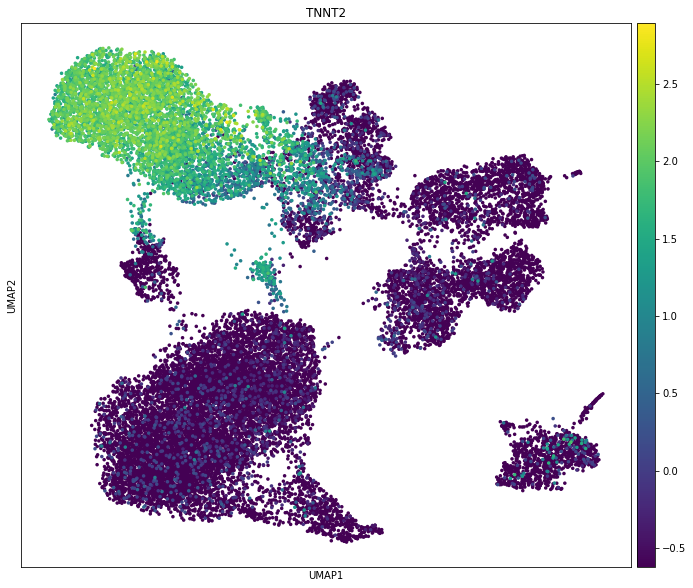

In [17]:
fig, ax = plt.subplots(figsize=(12,10))
sc.pl.umap(
    adata, 
    color=['TNNT2'],
        size=50,
            use_raw=False,
    ax=ax
)

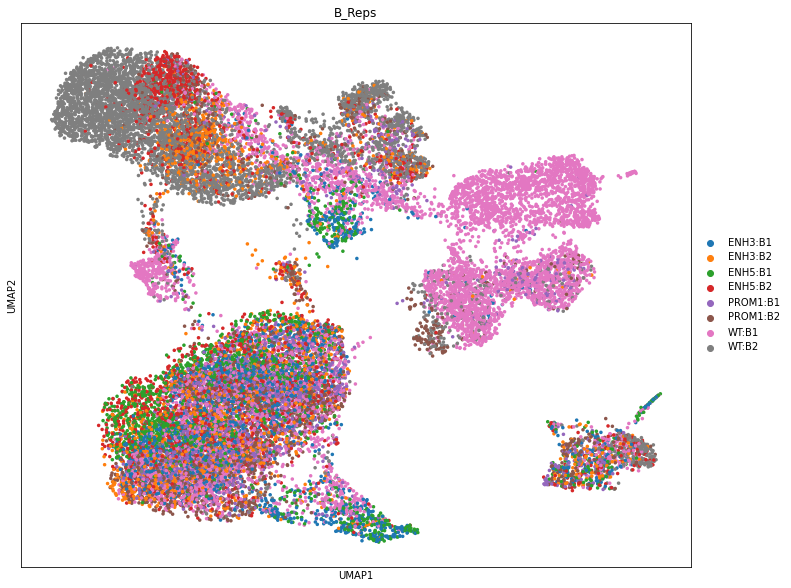

In [18]:
fig, ax = plt.subplots(figsize=(12,10))
sc.pl.umap(
    adata, 
    color=['B_Reps'],
        size=50,
            use_raw=False,
    ax=ax
)

In [19]:
sc.tl.rank_genes_groups(adata, 'louvain', method='wilcoxon')

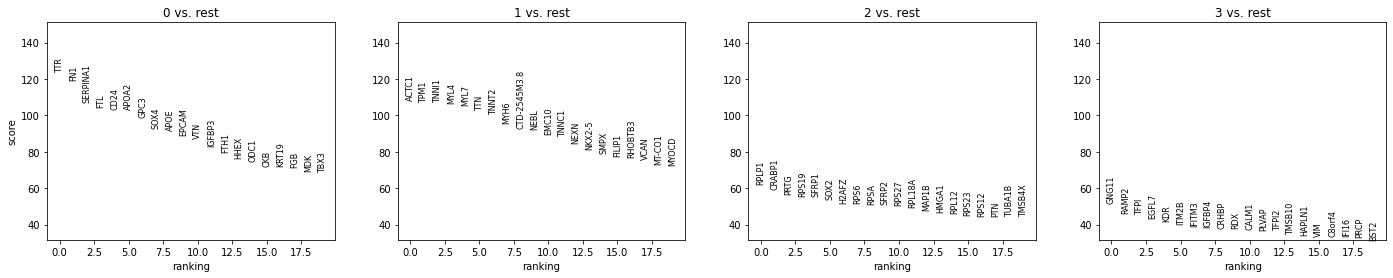

In [20]:
sc.pl.rank_genes_groups(adata)

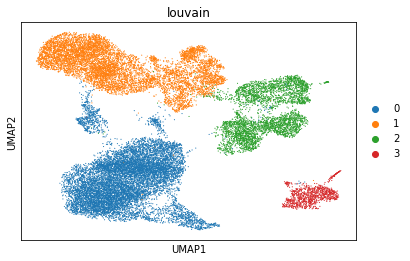

In [21]:
sc.pl.umap(
    adata,
    color=['louvain'], 
    vmin=0, vmax= 100
)

### Plot sample distributions

In [22]:
Sample_List = ['WT:B1', 'PROM1:B1', 'ENH3:B1', 'ENH5:B1', 'WT:B2', 'PROM1:B2', 'ENH3:B2', 'ENH5:B2']
Sample_Col = [0,1,2,3,0,1,2,3]

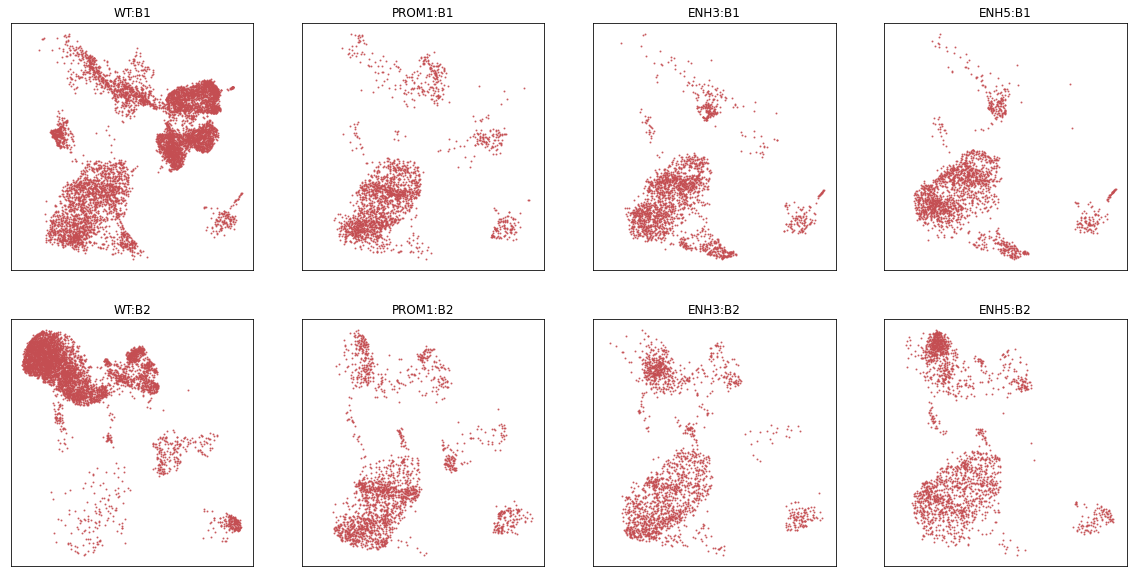

In [23]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20,10), sharex=True)

for i,sample in enumerate(Sample_List):
    sg_pos_cell = []
    for bc in adata.obs.index:
        if bc in adata[adata.obs['B_Reps'] == sample].obs.index:
            sg_pos_cell.append(1)
        else:
            sg_pos_cell.append(0)
    
    
    
    if sample.split(':')[1] == 'B1':
        row_set = 0
    else:
        row_set = 1
    col_set = Sample_Col[i]
        
    ax=axes[row_set,col_set]
    
    indices = np.nonzero(sg_pos_cell)[0]
    x = adata.obsm['X_umap'][indices,0]
    y = adata.obsm['X_umap'][indices,1]
    ax.scatter(x, 
               y, 
               c='#c44e52',
               s=1,
            alpha=0.8)

    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(sample)
    ax.grid(False)

In [ ]:
adata.write('./DAPKO_BOTH.h5ad')